In [144]:
!pwd

/content/drive/My Drive/nalp


In [145]:
%cd /content/drive/MyDrive/nalp

/content/drive/MyDrive/nalp


In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 245kB 14.7MB/s 
     |████████████████████████████████| 23.9MB 1.8MB/s 
     |████████████████████████████████| 10.3MB 29.7MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.5MB 52.0MB/s 
     |████████████████████████████████| 358kB 37.8MB/s 
     |████████████████████████████████| 286kB 52.3MB/s 
     |████████████████████████████████| 225kB 50.0MB/s 
     |████████████████████████████████| 112kB 43.2MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 747kB 40.1MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.

In [4]:
!pip install nalp

     |████████████████████████████████| 81kB 7.1MB/s 


In [5]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/nalp
  Found existing installation: nalp 2.0.2
    Uninstalling nalp-2.0.2:
      Successfully uninstalled nalp-2.0.2
  Running setup.py develop for nalp


In [6]:
!pip install tensorflow_text

     |████████████████████████████████| 4.3MB 14.5MB/s 


In [248]:
%cd /content/drive/MyDrive/nalp/examples/models

/content/drive/MyDrive/nalp/examples/models


In [8]:
!pip install -q tensorflow_datasets

In [249]:
!python ./train_relgan.py

2021-06-10 01:54:04.855730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-10 01:54:08.248780: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-10 01:54:08.259150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-10 01:54:08.259820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-06-10 01:54:08.259873: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-10 01:54:08.263534: I tensorflow/stream_executor/plat

In [251]:
%cd /content/drive/My Drive/nalp

/content/drive/My Drive/nalp


In [256]:
import tensorflow as tf
import random, nltk
import numpy as np
import tensorflow_datasets as tfds

from nalp.corpus import TextCorpus
from nalp.datasets import LanguageModelingDataset
from nalp.encoders import TransformerTokenizer
from nalp.models import RelGAN
from nalp.utils.transformer_utils import make_batches
from nalp.utils.constants import BUFFER_SIZE

corpus = TextCorpus(from_file='./data/text/wiki_vitranslated_small.txt', corpus_type="word")

# model_name = "../../nalp/encoders/wiki_tokenizers_2"
# tokenizers = tf.saved_model.load(model_name)
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)
tokenizers = tf.saved_model.load(model_name)

sequences = corpus.sequences.copy()

encoded_good_tokens = tokenizers.en.tokenize(sequences)

dataset = tf.data.Dataset.from_tensor_slices(encoded_good_tokens)

dataset = tf.keras.preprocessing.sequence.pad_sequences(list(dataset.as_numpy_iterator()), maxlen=200, dtype='int64',
                                                          padding='post')

dataset = tf.data.Dataset.from_tensor_slices(dataset)

def tokenize(en):
    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return en

BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
    return (
        ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            # .map(tokenize, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
        
# dataset = tf.data.Dataset.from_tensor_slices(sequences)

# def tokenize(en):
#     en = tokenizers.en.tokenize(en)
#     # Convert from ragged to dense, padding with zeros.
#     en = en.to_tensor()
#     return en


# BUFFER_SIZE = 20000
# BATCH_SIZE = 64

# def make_batches(ds):
#     return (
#         ds
#             .cache()
#             .shuffle(BUFFER_SIZE)
#             .batch(BATCH_SIZE)
#             .map(tokenize, num_parallel_calls=tf.data.AUTOTUNE)
#             .prefetch(tf.data.AUTOTUNE))


# TODO: train and validation split?
train_batches = make_batches(dataset)


good_corpus = TextCorpus(from_file='./data/text/wiki_good_sentences.txt', corpus_type='word')

sequences = tf.data.Dataset.from_tensor_slices(good_corpus.sequences)

good_datasets = sequences

# good maximum length
good_max_continuous_pad_length = 0
# for inp in good_datasets:
#     shape = inp.shape
#     if shape[1] > good_max_continuous_pad_length:
#         good_max_continuous_pad_length = shape[1]

# Creating the RelGAN
num_layers = 4
d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.1

#TODO: check vocab size
relgan = RelGAN(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=tokenizers.en.get_vocab_size(), target_vocab_size=tokenizers.en.get_vocab_size(),
                pe_input=1000, pe_target=1000, dropout_rate=dropout_rate,
                max_length=good_max_continuous_pad_length - 1, n_filters=(64, 128, 256), filters_size=(3, 5, 5), tau=5, tokenizers=tokenizers)

# Saving RelGAN weights
relgan.load_weights('./examples/models/trained/relgan4')


2021-06-10 03:22:17,019 - nalp.corpus.text — INFO — Overriding class: Corpus -> TextCorpus.
2021-06-10 03:22:17,022 - nalp.utils.loader — DEBUG — Loading ./data/text/wiki_vitranslated_small.txt ...
2021-06-10 03:22:17,033 - nalp.utils.preprocess — DEBUG — Pipeline created with (<function lower_case at 0x7f489cb4a4d0>, <function valid_char at 0x7f489cb558c0>, <function tokenize_to_word at 0x7f489cb559e0>).
2021-06-10 03:22:17,275 - nalp.corpus.text — DEBUG — Tokens: 191120 | Minimum frequency: 1 | Vocabulary size: 24029.
2021-06-10 03:22:17,277 - nalp.corpus.text — INFO — TextCorpus created.
2021-06-10 03:22:21,532 - nalp.corpus.text — INFO — Overriding class: Corpus -> TextCorpus.
2021-06-10 03:22:21,534 - nalp.utils.loader — DEBUG — Loading ./data/text/wiki_good_sentences.txt ...
2021-06-10 03:22:21,546 - nalp.utils.preprocess — DEBUG — Pipeline created with (<function lower_case at 0x7f489cb4a4d0>, <function valid_char at 0x7f489cb558c0>, <function tokenize_to_word at 0x7f489cb559e0>

In [257]:
import tensorflow as tf
from nalp.utils.transformer_utils import create_masks
import time


def evaluate(tokenizers, sentence, transformer, max_length=40):
  start_time = time.time()

  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.en.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  start_time = time.time()
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, _, _, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break


  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights


def print_improvement(sentence, prediction):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {prediction.numpy().decode("utf-8")}')

In [258]:
relgan.G

In [259]:
sentence = 'Right at the time when he had recently passed a ban on minarets.'
improved_text, improved_tokens, attention_weights = evaluate(tokenizers, sentence, relgan.G)

In [260]:
print_improvement(sentence, improved_text)

Input:         : Right at the time when he had recently passed a ban on minarets.
Prediction     : right at the time when he had recently passed a ban on minarets .


# Plot

In [208]:
training_log = """
2021-06-09 20:19:42,317 - nalp.models.relgan — INFO — Epoch 1/20
2021-06-09 20:20:19,256 - nalp.models.relgan — INFO — Loss(G): 8.209006
2021-06-09 20:20:19,257 - nalp.models.relgan — INFO — accuracy(G): 0.040683497
2021-06-09 20:20:19,257 - nalp.models.relgan — INFO — Epoch 2/20
2021-06-09 20:20:42,716 - nalp.models.relgan — INFO — Loss(G): 6.5572004
2021-06-09 20:20:42,717 - nalp.models.relgan — INFO — accuracy(G): 0.09678834
2021-06-09 20:20:42,717 - nalp.models.relgan — INFO — Epoch 3/20
2021-06-09 20:21:06,163 - nalp.models.relgan — INFO — Loss(G): 5.8267665
2021-06-09 20:21:06,164 - nalp.models.relgan — INFO — accuracy(G): 0.16996104
2021-06-09 20:21:06,164 - nalp.models.relgan — INFO — Epoch 4/20
2021-06-09 20:21:29,494 - nalp.models.relgan — INFO — Loss(G): 5.1689005
2021-06-09 20:21:29,495 - nalp.models.relgan — INFO — accuracy(G): 0.2310513
2021-06-09 20:21:29,495 - nalp.models.relgan — INFO — Epoch 5/20
2021-06-09 20:21:53,076 - nalp.models.relgan — INFO — Loss(G): 4.674359
2021-06-09 20:21:53,077 - nalp.models.relgan — INFO — accuracy(G): 0.28080773
2021-06-09 20:21:53,077 - nalp.models.relgan — INFO — Epoch 6/20
2021-06-09 20:22:16,920 - nalp.models.relgan — INFO — Loss(G): 3.9028943
2021-06-09 20:22:16,921 - nalp.models.relgan — INFO — accuracy(G): 0.3904159
2021-06-09 20:22:16,921 - nalp.models.relgan — INFO — Epoch 7/20
2021-06-09 20:22:40,217 - nalp.models.relgan — INFO — Loss(G): 2.8584423
2021-06-09 20:22:40,218 - nalp.models.relgan — INFO — accuracy(G): 0.55090505
2021-06-09 20:22:40,218 - nalp.models.relgan — INFO — Epoch 8/20
2021-06-09 20:23:03,600 - nalp.models.relgan — INFO — Loss(G): 2.0056882
2021-06-09 20:23:03,601 - nalp.models.relgan — INFO — accuracy(G): 0.6803012
2021-06-09 20:23:03,602 - nalp.models.relgan — INFO — Epoch 9/20
2021-06-09 20:23:26,961 - nalp.models.relgan — INFO — Loss(G): 1.377992
2021-06-09 20:23:26,962 - nalp.models.relgan — INFO — accuracy(G): 0.77528226
2021-06-09 20:23:26,962 - nalp.models.relgan — INFO — Epoch 10/20
2021-06-09 20:23:50,342 - nalp.models.relgan — INFO — Loss(G): 0.9471684
2021-06-09 20:23:50,343 - nalp.models.relgan — INFO — accuracy(G): 0.8418075
2021-06-09 20:23:50,343 - nalp.models.relgan — INFO — Epoch 11/20
2021-06-09 20:24:13,999 - nalp.models.relgan — INFO — Loss(G): 0.61048007
2021-06-09 20:24:14,000 - nalp.models.relgan — INFO — accuracy(G): 0.8976377
2021-06-09 20:24:14,000 - nalp.models.relgan — INFO — Epoch 12/20
2021-06-09 20:24:37,376 - nalp.models.relgan — INFO — Loss(G): 0.40931103
2021-06-09 20:24:37,377 - nalp.models.relgan — INFO — accuracy(G): 0.93139523
2021-06-09 20:24:37,377 - nalp.models.relgan — INFO — Epoch 13/20
2021-06-09 20:25:00,760 - nalp.models.relgan — INFO — Loss(G): 0.30422294
2021-06-09 20:25:00,761 - nalp.models.relgan — INFO — accuracy(G): 0.9491191
2021-06-09 20:25:00,761 - nalp.models.relgan — INFO — Epoch 14/20
2021-06-09 20:25:24,399 - nalp.models.relgan — INFO — Loss(G): 0.23381454
2021-06-09 20:25:24,400 - nalp.models.relgan — INFO — accuracy(G): 0.9608931
2021-06-09 20:25:24,400 - nalp.models.relgan — INFO — Epoch 15/20
2021-06-09 20:25:48,078 - nalp.models.relgan — INFO — Loss(G): 0.1829627
2021-06-09 20:25:48,079 - nalp.models.relgan — INFO — accuracy(G): 0.9696837
2021-06-09 20:25:48,080 - nalp.models.relgan — INFO — Epoch 16/20
2021-06-09 20:26:11,592 - nalp.models.relgan — INFO — Loss(G): 0.15542105
2021-06-09 20:26:11,593 - nalp.models.relgan — INFO — accuracy(G): 0.9747417
2021-06-09 20:26:11,594 - nalp.models.relgan — INFO — Epoch 17/20
2021-06-09 20:26:35,114 - nalp.models.relgan — INFO — Loss(G): 0.13219489
2021-06-09 20:26:35,115 - nalp.models.relgan — INFO — accuracy(G): 0.9786656
2021-06-09 20:26:35,115 - nalp.models.relgan — INFO — Epoch 18/20
2021-06-09 20:26:58,547 - nalp.models.relgan — INFO — Loss(G): 0.124398984
2021-06-09 20:26:58,548 - nalp.models.relgan — INFO — accuracy(G): 0.98019165
2021-06-09 20:26:58,548 - nalp.models.relgan — INFO — Epoch 19/20
2021-06-09 20:27:22,351 - nalp.models.relgan — INFO — Loss(G): 0.10516842
2021-06-09 20:27:22,352 - nalp.models.relgan — INFO — accuracy(G): 0.98341775
2021-06-09 20:27:22,352 - nalp.models.relgan — INFO — Epoch 20/20
2021-06-09 20:27:46,018 - nalp.models.relgan — INFO — Loss(G): 0.08950414
2021-06-09 20:27:46,019 - nalp.models.relgan — INFO — accuracy(G): 0.9860321

"""

In [209]:
accuracy = []
loss = []
lines = training_log.split('\n')

for line in lines:
  if 'Loss' in line:
    loss.append(float(line[line.find(': ') + 2:]))
  if 'accuracy' in line:
    accuracy.append(float(line[line.find(': ') + 2:]))

In [210]:
import pandas as pd

df = pd.DataFrame(data=list(zip(accuracy, loss)), columns=['training accuracy', 'training loss'])

In [211]:
df['epoch'] = list(range(1, 21))

In [212]:
import seaborn as sns

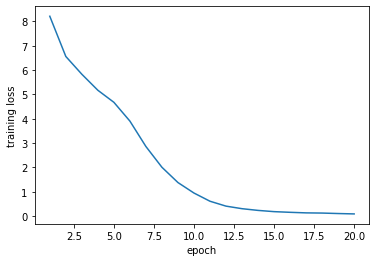

In [213]:
sns.lineplot(data=df, x='epoch', y = 'training loss')

In [196]:
training_log = """
2021-06-09 23:03:07,992 - nalp.models.relgan — INFO — Loss(G): 0.006389252 | Loss(D): 1.3876519
2021-06-09 23:03:07,993 - nalp.models.relgan — INFO — Epoch 2/10
2021-06-09 23:03:48,704 - nalp.models.relgan — INFO — Loss(G): -0.0014623454 | Loss(D): 1.3876511
2021-06-09 23:03:48,705 - nalp.models.relgan — INFO — Epoch 3/10
2021-06-09 23:04:29,458 - nalp.models.relgan — INFO — Loss(G): -0.008612099 | Loss(D): 1.3876508
2021-06-09 23:04:29,459 - nalp.models.relgan — INFO — Epoch 4/10
2021-06-09 23:05:10,212 - nalp.models.relgan — INFO — Loss(G): -0.014414995 | Loss(D): 1.3876517
2021-06-09 23:05:10,212 - nalp.models.relgan — INFO — Epoch 5/10
2021-06-09 23:05:50,966 - nalp.models.relgan — INFO — Loss(G): -0.018895369 | Loss(D): 1.3876508
2021-06-09 23:05:50,967 - nalp.models.relgan — INFO — Epoch 6/10
2021-06-09 23:06:31,835 - nalp.models.relgan — INFO — Loss(G): -0.023521626 | Loss(D): 1.3876519
2021-06-09 23:06:31,835 - nalp.models.relgan — INFO — Epoch 7/10
2021-06-09 23:07:12,624 - nalp.models.relgan — INFO — Loss(G): -0.026962511 | Loss(D): 1.3876511
2021-06-09 23:07:12,624 - nalp.models.relgan — INFO — Epoch 8/10
2021-06-09 23:07:53,319 - nalp.models.relgan — INFO — Loss(G): -0.03387619 | Loss(D): 1.3876511
2021-06-09 23:07:53,319 - nalp.models.relgan — INFO — Epoch 9/10
2021-06-09 23:08:34,071 - nalp.models.relgan — INFO — Loss(G): -0.03343583 | Loss(D): 1.3876516
2021-06-09 23:08:34,072 - nalp.models.relgan — INFO — Epoch 10/10
2021-06-09 23:09:14,807 - nalp.models.relgan — INFO — Loss(G): -0.036674697 | Loss(D): 1.3876516"""

In [197]:
G_loss = []
D_loss = []

lines = training_log.split('\n')

for line in lines:
  if 'Loss(G)' in line:
    G_loss.append(float(line[line.find('Loss(G)') + 9: line.find('Loss(G)') + 18].strip()))
  if 'Loss(D)' in line:
    D_loss.append(float(line[line.find('Loss(D)') + 9: ]))

In [198]:
import pandas as pd

df = pd.DataFrame(data=list(zip(G_loss, D_loss)), columns=['G_loss', 'D_loss'])

In [199]:
df['epoch'] = list(range(1, 11))

In [200]:
G_loss

[0.0063892,
 -0.001462,
 -0.008612,
 -0.014414,
 -0.018895,
 -0.023521,
 -0.026962,
 -0.033876,
 -0.033435,
 -0.036674]

In [201]:
df

,G_loss,D_loss,epoch
0,0.006389,1.387652,1
1,-0.001462,1.387651,2
2,-0.008612,1.387651,3
3,-0.014414,1.387652,4
4,-0.018895,1.387651,5
5,-0.023521,1.387652,6
6,-0.026962,1.387651,7
7,-0.033876,1.387651,8
8,-0.033435,1.387652,9
9,-0.036674,1.387652,10


In [202]:
losses = pd.concat([df['G_loss'], df['D_loss']])

In [203]:
label = ['G_loss'] * 10 + ['D_loss'] * 10

In [204]:
df = pd.DataFrame(data=list(zip(losses, label)), columns=['losses', 'label'])

In [205]:
df['epoch'] = list(range(1, 11)) + list(range(1, 11))

In [206]:
df

,losses,label,epoch
0,0.006389,G_loss,1
1,-0.001462,G_loss,2
2,-0.008612,G_loss,3
3,-0.014414,G_loss,4
4,-0.018895,G_loss,5
5,-0.023521,G_loss,6
6,-0.026962,G_loss,7
7,-0.033876,G_loss,8
8,-0.033435,G_loss,9
9,-0.036674,G_loss,10


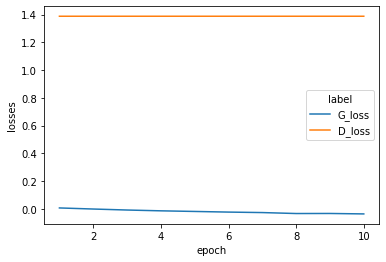

In [207]:
sns.lineplot(data=df, x='epoch', y = 'losses', hue='label')

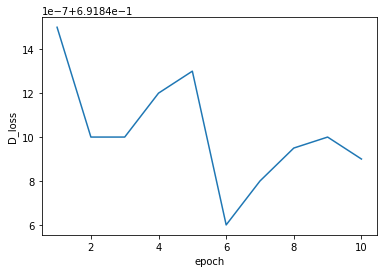

In [128]:
sns.lineplot(data=df, x='epoch', y = 'D_loss')

In [114]:
G_loss

['0.6944552',
 '0.6944559',
 '0.6944556',
 '0.694456 ',
 '0.6944555',
 '0.6944558',
 '0.6944559',
 '0.6944563',
 '0.6944563',
 '0.6944558']

In [115]:
D_loss

['0.6918415',
 '0.691841',
 '0.691841',
 '0.6918412',
 '0.6918413',
 '0.6918406',
 '0.6918408',
 '0.69184095',
 '0.691841',
 '0.6918409']